# Calibrate using a recursive Bayesian filter

In this tutorial we explain the process of calibrating the economic component of the hydro-economic model using using a recursive Bayesian approach to the positive mathematical programming method. The algorithm is based on [Maneta and Howitt (2014)](https://doi.org/10.1002/2013WR015196). In this methodology, the parameters are represented by a stochastic ensemble that approximate their probability distribution. The parameter ensembles are updated by assimilating new observations as they becomme available. The updates occur during an assimilation process that blends information from new and past observations. By blending information, the methodology results in a dynamic parameter ensemble that does not represent the economic behavior observed during a specific year but rather a mid-term average of the observations. The spread of the ensemble represent the confidence that we have in the quality observations as well as the expected spatial variations of producer behavior in the spatial region represented by the farm.  

Like in the standard PMP calibration, the filter uses the `Farm class` included in the `econengine` module to represent a regional aggregation of producers. Stochastic parameter calibration is handled by the `kalmanfilter` class, which is part of the `assimilation` module. The interface of the `kalmanfilter` class has two  main methods: `assimilate(**obs)` and `simulate(**scenario)`. Whenever new observations of agricultural activity are available for a given  we can load creating a `Farm` and a `kalmanfilter` object, and calling the main methods of the latter class with the appropriate observation specification dictionary or scenario specification dictionary. to update the parameters or simulate scenarios, respectively.  

In this tutorial we will recursively calibrate a small case study (Ravalli county) simulating a sequence of 10 years of observations. To use the stochastic calibration we need to import the Kalman filter function from the `assimilation` module. We will also import the `plotting` module for a quick visualization of the results. 

The input data files are very similar to the one used for the standard PMP calibration and simulation. The only difference is that the observations file contains data on the mean and standard deviation of the parameters. In fact, this file structure is also valid for a PMP calibration (only in that case the std data will not be used).

In [27]:
# load standard packages
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd

# load packages from DAWUAP
import utils
from econengine import econfuncs
from assimilation import kalmanfilter
import plotting

## Reading the farm definition file and creating a 'farm' object

After loading the necessary modules, the first step is to read the farm definition file, which is a dictionary containing a `farm` key. This key holds a list of dictionaries containing information on the farms to be simulated. The dictionary is read as a json file. The [section on the farm definition dictionary](file.html) provides a description of the file format and the keys that should be in the dictionary. 

In this tutorial we will load a farm definition file with a single 'farm' representing all producers in Ravalli county, western Montana and use this inforamtion to create a `Farm` object with name 'farm_Ravalli'.

In [28]:
# __ Read and format the input data __\n",

# load farm definition file
with open('../ClarkForkTutorial/econ_stochastic/Farms_Ravalli.json') as farms:
    dct_farms = json.load(farms)
    
Ravalli = dct_farms['farms'][0] # Ravalli county is the first (and only) farm in the list for 'farms'

# create a farm object for Ravalli County,
farm_Ravalli = econfuncs.Farm(**Ravalli)

## Reading observations used for calibration

The stochastic nature of the filter requires that the observation specification file includes the mean and variance of the observations, as described in the [documentation](stochastic_observations.html). The observation file in this example includes observations for Ravalli county for year 2012. 


In [29]:
# load observation definition file,
with open('../ClarkForkTutorial/econ_stochastic/observations/observations_Ravalli_2012.json') as obs:
    obs_Ravalli = json.load(obs)

## Creating a KalmanFilter object and assimilating observations

The parameter ensembles are managed by a class named `KalmanFiter`. Objects of this class permit to assimilate observations, run simulations and save results. If a prior parameter ensemble file does not exist, a KalmanFilter object is created from scratch with information on the size of the ensemle, a `Farm` object, and the amount of spread (variance) desired in the initial parameter ensemble.

In the example below we are creating an initial `KalmanFilter` object initiated with a parameter ensemble of 300 members for farm_Ravalli. The initial ensemble is created with a standard deviation 3 times the parameter mean (coefficient of variation `cv`=3). The initial parameter mean is obtained from the `Farm` object (farm_Ravalli). Once a KalmanFilter is generated, new observations are ingested using the `assimilate` method of the `KalmamFilter` object and the updated ensemble can be saved with the `save_kalman_filter` method. Once an ensemble exists, a `KalmanFilter` object can be created by loading the parameter ensemble information file, updated again by assimilating new observations and saving the updated parameter ensemble. 

In this tutorial we will assimilate 10 years of observations for Ravalli county from 2002 to 2011. For simplicity and illustration purposes we will assume that the observations of agricultural activity for all these 10 years are identical to these of year 2012, so we will assimilate in a loop the same observation (obs_Ravalli) specification we loaded earlier. 

In [30]:
# create an initial KalmanFilter object; we define the size of the ensemble, pass on the
# farm definition object, set the coefficient of variation to 3 (that is, large) 
kf = kalmanfilter.KalmanFilter(ens_size=300, farm=farm_Ravalli, cv=3, xi=0.98)

# calibration loop (loop over years)
for y in range(2002, 2012):
    print 'Assimilating year', y
    kf.assimilate(obs_Ravalli[0]) # <-- KEY ASSIMILATION METHOD TO UPDATE THE PARAMETER ENSEMBLE WITH OBSERVATIONS
    #SAVE THE UPDATED KALMAN FILTER TO THE SPECIFIED FOLDER
    kf.save_kalman_filter('../ClarkForkTutorial/econ_stochastic/parameter_ensembles', timestep_label=str(y))
    # LOAD THE EXISTING PARAMETER ENSEMBLE FOR RAVALLI COUNTY AND GENERATE A KALMAN FILTER OBJECT  
    kf = kalmanfilter.KalmanFilter(farm=farm_Ravalli, 
                                   fn_info_file='../ClarkForkTutorial/econ_stochastic/parameter_ensembles/30081_kf_info.json')

Assimilating year 2002
Ensemble ../ClarkForkTutorial/econ_stochastic/parameter_ensembles/30081_kf_info.json exists, overwrite (Y/N)?Y
Y
Overwritting ensemble ../ClarkForkTutorial/econ_stochastic/parameter_ensembles/30081_kf_info.json.... 
Assimilating year 2003
Assimilating year 2004
Assimilating year 2005
Assimilating year 2006
Assimilating year 2007
Assimilating year 2008
Assimilating year 2009
Assimilating year 2010
Assimilating year 2011


## Quick inspection of parameter ensembles

When a `KalmanFilter` object for a particular `Farm` is saved, it writes to disk an information file along with a parameter ensemble file and another file with the ensemble of innovations. The name of the files written to disk always start with the id of hte `Farm` object they represent. 

The parameter ensemble file stores the evolution of the probability distribution of the model parameters as it converges toward their true distribution during each successive assimilation cycle. The innovation ensemble file stores the difference between the probability distribution of marginal revenues and marginal costs given the model parameters. If the model is properly calibrated the sequence of innovations should have mean zero and a variance that reflect the total variance of hte model (parameters and observations). When the sequence of innovations do not converge toward zero or their mean values is significanlty different from zero the calibration is suboptimal.

To inspect the state of the calibration process, the `plotting` module contains tools to load the kalman filter files, plot the ensemble and calculate basic statistics. An `EnsembleResults` object can be created by passing the name of the *kf_info.json* file of interest. Once the object is created, methods to plot the sequence of parameter ensembles and the sequence of innovation ensembles are avilable. This libray is still in an early best state.  

PLOT PARAMETER ENSEMBLES FOR BARLEY
-------------------------------
betas Barley Irrigated_1
betas Barley Irrigated_2
betas Barley Nonirrigated_1
betas Barley Nonirrigated_2
deltas Barley Irrigated
deltas Barley Nonirrigated
first_stage_lambda A
lambdas_land Barley Irrigated_1
lambdas_land Barley Irrigated_2
lambdas_land Barley Nonirrigated_1
lambdas_land Barley Nonirrigated_2
mus Barley Irrigated
mus Barley Nonirrigated


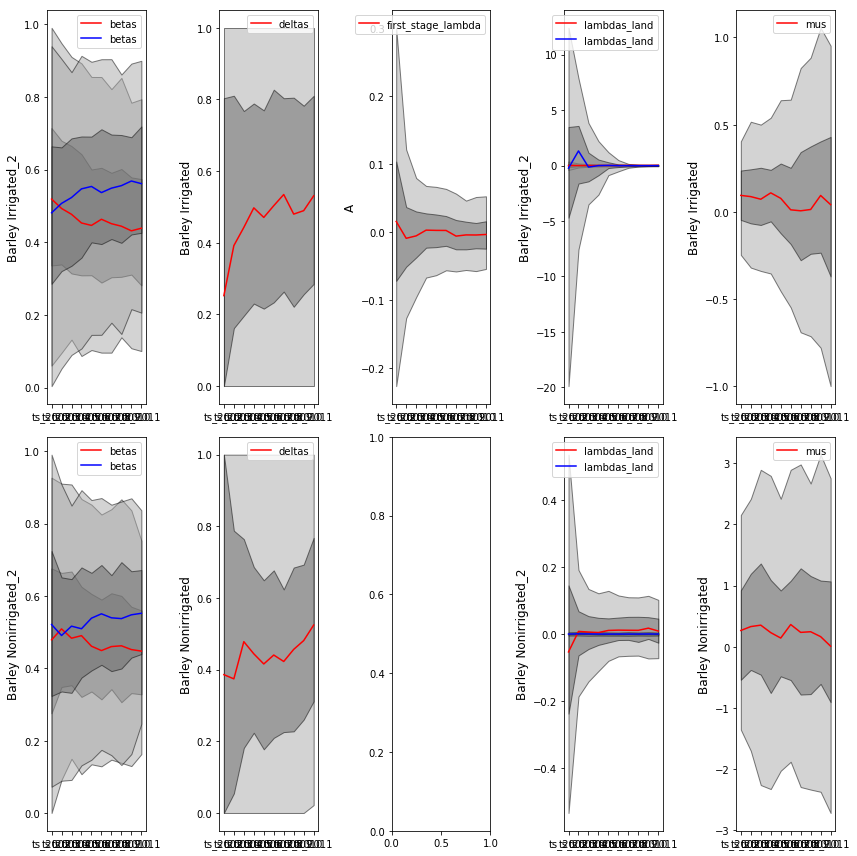

PLOT THE INNOVATION SEQUENCE
-----------------------------
betas Alfalfa Irrigated_1
betas Alfalfa Irrigated_2
betas Alfalfa Nonirrigated_1
betas Alfalfa Nonirrigated_2
deltas Alfalfa Irrigated
deltas Alfalfa Nonirrigated
first_stage_lambda A
lambdas_land Alfalfa Irrigated_1
lambdas_land Alfalfa Irrigated_2
lambdas_land Alfalfa Nonirrigated_1
lambdas_land Alfalfa Nonirrigated_2
mus Alfalfa Irrigated
mus Alfalfa Nonirrigated


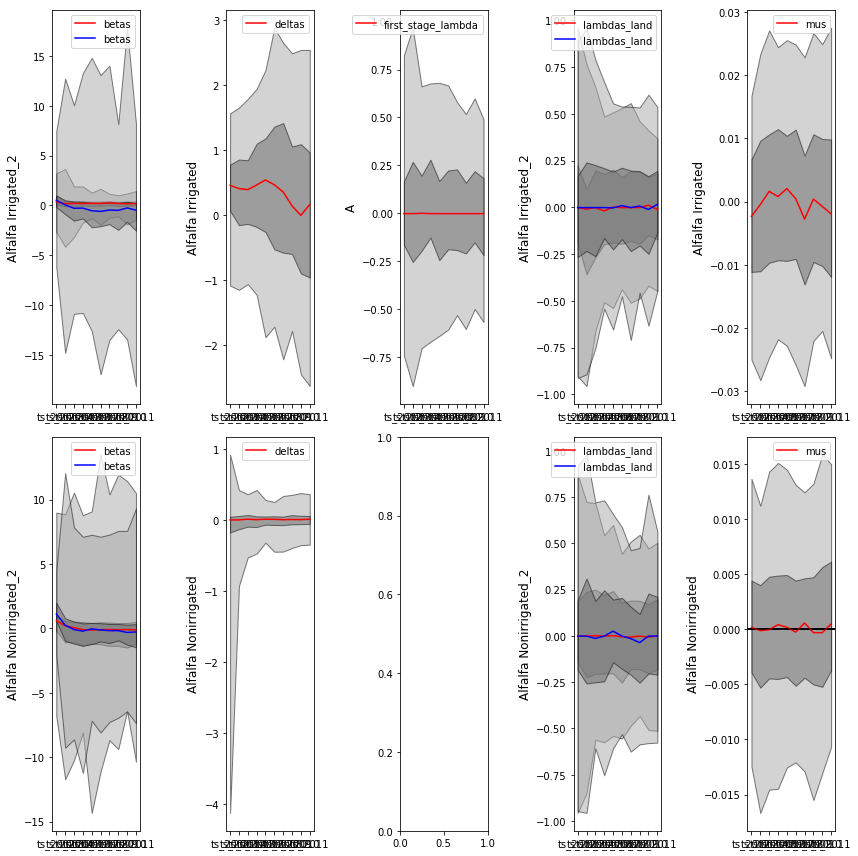

In [26]:
# __ Inspect the results __

# create an EnsembleResults object
ens = plotting.EnsembleResults('../ClarkForkTutorial/econ_stochastic/parameter_ensembles/30081_kf_info.json')

print "PLOT PARAMETER ENSEMBLES FOR BARLEY"
print "-------------------------------"
# plot the beta parameters for dryland alfalfa; we get two lines,
# one for water and one for land
ens.plot_parameter_ensemble(crop_lst=['Barley Irrigated', 'Barley Nonirrigated'], innovation=False)


print "PLOT THE INNOVATION SEQUENCE"
print "-----------------------------"
# plot the innovation; a value of 0 indicates convergence to optimality

ens.plot_parameter_ensemble(crop_lst=['Alfalfa Irrigated', 'Alfalfa Nonirrigated'], innovation=True)

# RUNNING A SIMULATION

The `KalmanFilter` class has a `simulate` method to perform a simulation with using the parameter distribution approximated by the calibration ensemble. The `simulate` method takes a [scenario definition file](scenarios.html) of identical format to the scenario file used induring a standard PMP calibration. 

The example below loads a scenario definition containing one element representing the 2012 conditions observed for Ravalli county. This file is then used to to perform a simulation that generates an ensemble of model outputs describing the probability distribution of resource allocations given the uncertian in the input parameters. The results are written in an HDF5 file as specified in the parameter `fn_write_ensemble_states` parameter of the `simulate` method. 

In [23]:
# __ Generate scenarios __

# a function to generate custom scenarios; the function takes two arguments:
# a dictionary with the observations (`obs`) and the year of the observations
# (`year`).
def generate_scenario(obs, year):
    # generate a dictionary to contain the scenario definion
    env = {
        'farm_id': obs['id'],
        'year': year,
        'evapotranspiration': np.array(obs['mean_obs_water']).tolist(),
        'prices': obs['mean_prices'],
        'costs': obs['mean_costs'],
        'land_constraint': np.sum(obs['mean_obs_land']).tolist(),
        'water_constraint': np.sum(obs['mean_obs_water']).tolist(),
        'crop_start_date': ["5/15/"+str(year), "5/15/"+str(year), "5/15/"+str(year), "5/15/"+str(year), "5/15/"+str(year),
            "5/15/"+str(year), "5/15/"+str(year), "5/15/"+str(year),"5/15/"+str(year), "5/15/"+str(year)],
        'crop_cover_date': ["7/02/"+str(year), "7/02/"+str(year), "7/02/"+str(year), "7/02/"+str(year), "7/02/"+str(year),
            "7/02/"+str(year), "7/02/"+str(year), "7/02/"+str(year),"7/02/"+str(year), "7/02/"+str(year)],
        'crop_end_date': ["8/25/"+str(year), "8/25/"+str(year), "8/25/"+str(year), "8/25/"+str(year), "8/25/"+str(year),
            "8/25/"+str(year), "8/25/"+str(year), "8/25/"+str(year),"8/25/"+str(year), "8/25/"+str(year)], 
    }
    return(env)

# create an empty list to store the scenarios (there'd be one scenario per farm)
lst_scenarios = []

# fill in the previous object with scenarios for each farm, using information
# from obs (created in the previous code chunk) and the generator function we just defined
for o in obs_Ravalli:
    lst_scenarios.append(generate_scenario(o, 2012))

# save the baseline scenario under name 'baseline_scenario.json' 
with open('../ClarkForkTutorial/econ_stochastic/scenarios/baseline_scenario.json', 'w') as sce:
     json.dump(lst_scenarios, sce)
        

In [13]:
# create an initial KalmanFilter object; we define the size of the ensemble, pass on the
# farm definition object, set the coefficient of variation to 3 (that is, large) 
kf = kalmanfilter.KalmanFilter(ens_size=300, farm=farm_Ravalli, cv=3)
# __ Run a simulation __

# load the scenarios file
with open('../ClarkForkTutorial/econ_stochastic/scenarios/baseline_scenario.json', 'r') as scen:
    lst_scenarios = json.load(scen)
    
# produce stochastic simulations
kf.simulate(dict_scenario=lst_scenarios[0], fn_write_ensemble_states='../ClarkForkTutorial/econ_stochastic/scenarios/4_baseline.h5');

  0%|          | 0/300 [00:00<?, ?members/s]/home/maneta/anaconda2/envs/dawuap/lib/python2.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
  1%|▏         | 4/300 [00:12<15:22,  3.11s/members]


KeyboardInterrupt: 

## PLOTTING SIMULATION RESULTS

The HDF5 files with the ensemble of simulated results can easily be read into a MultiIndex pandas DataFrame for further plotting and analysis. The DataFrame obtained reading the HDF5 file is organizesd such that each column represents a simulated variable (e.g. 'used_land' or 'used_water'), the first level of the index represents a member of the simulation ensemble, and the second member is the simulated crop. 

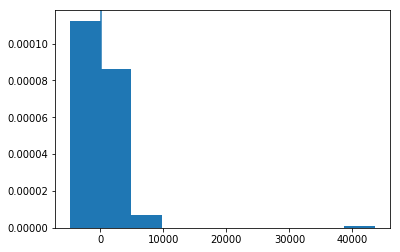

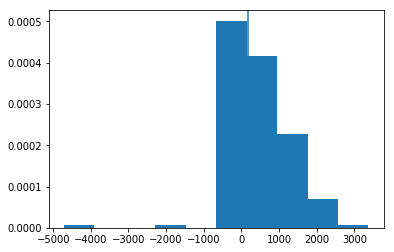

In [78]:
# plot something
df = pd.read_hdf('../ClarkForkTutorial/econ_stochastic/scenarios/4_baseline.h5', mode='r+')


# produce un histograma del land allocation to different crops
plt.hist(df['used_land'].unstack()['Alfalfa Irrigated'], density=True)
plt.axvline(111)

plt.figure()
plt.hist(df['used_land'].unstack()['Alfalfa Nonirrigated'], density=True)
plt.axvline(187)

#plt.figure()
#plt.hist(df['shadow_price_water'].unstack(), normed=True)

In [76]:


#obs_Ravalli

print (obs_Ravalli[0][u'mean_obs_land'])
#print (obs_Ravalli[0][u'mean_obs_water'])

[6522.74970886708, 305.910291132919, 111.181045367028, 187.078954632972, 220.14, 522.020454545455, 243.60954545454499, 154.62]


In [81]:
lnd = pd.DataFrame(df['used_land'].unstack().mean())
lnd['obs'] = obs_Ravalli[0][u'mean_obs_land']
print lnd
#print df['used_water'].unstack().mean()

AttributeError: 'list' object has no attribute 'mean'

In [24]:
# create a farm object for Ravalli County,
farm_Ravalli = econfuncs.Farm(**Ravalli)

# load the scenarios file
with open('../ClarkForkTutorial/econ_stochastic/scenarios/baseline_scenario.json', 'r') as scen:
    lst_scenarios = json.load(scen)
    

print "params before calib"
print farm_Ravalli.write_farm_dict()['parameters']
farm_Ravalli.simulate(**lst_scenarios[0])
print "result before calib"
print farm_Ravalli.write_farm_dict()['simulated_states']['used_land']
farm_Ravalli.calibrate(**obs_Ravalli[0])
print "params after calib"
print farm_Ravalli.write_farm_dict()['parameters']
farm_Ravalli.simulate(**lst_scenarios[0])
print "results after calib"
print farm_Ravalli.write_farm_dict()['simulated_states']['used_land']
print "obs"
print (obs_Ravalli[0][u'mean_obs_land'])
print lst_scenarios

params before calib
{'deltas': [0.276, 0.227, 0.225, 0.574, 0.276, 0.507, 0.276, 0.227], 'mus': [0.153, 0.082, 0.056, 0.327, 0.038, 0.427, 0.153, 0.082], 'lambdas_land': [[-0.076, 0.0], [-0.6362336505496803, 0.0], [-1.4425777862249356, -6.482169427343296], [-0.5028690941515698, 0.0], [-0.41119281063122387, -2.6880072430400057], [0.024232063421729032, 0.0], [-0.076, 0.0], [-0.6362336505496803, 0.0]], 'first_stage_lambda': [-0.165], 'betas': [[0.947, 0.053], [0.288, 0.712], [0.053, 0.947], [0.858, 0.142], [0.782, 0.218], [0.974, 0.026], [0.947, 0.053], [0.288, 0.712]], 'sigmas': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]}
result before calib
[0.5523726907459598, 0.016228209485686908, 8260.310647977829, 1.1873273247674092, 1.0234206079895503, 0.7022953676007793, 1.3341773815616105, 1.9083012307104898]
Farm Ravalli with id 30081 successfully calibrated
params after calib
{'deltas': [0.7384221787584944, 0.16907347678062531, 0.25935230872175935, 0.25941657607554247, 0.27333611124412016, 0.2756